## 2) Dimensionality Reduction

We currently have 26 features to characterise every timeseries, where inevitably, some information has been lost from the original dataset. We will use PCA and/or LDA to perform further dimensionality reduction in the dataset.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
df = pd.read_csv(r"data/transformed_df.csv").drop("Unnamed: 0", axis=1)
df.head()

,mean,std,var,min,max,skew,kurtosis,rms,zero_crossings,abs_max,...,alpha_power,beta_power,gamma_power,wavelet_energy_level_0,wavelet_energy_level_1,wavelet_energy_level_2,wavelet_energy_level_3,wavelet_energy_level_4,approx_entropy,y
0,-16.910112,95.980947,9212.342157,-281.0,229.0,-0.200327,0.067411,97.193309,23.0,281.0,...,3184.617042,5194.059337,90.945865,3.690802e+06,1.535263e+05,7.258087e+05,1.070282e+05,7569.491844,0.674851,0
1,28.112360,473.166815,223886.834762,-1716.0,513.0,-1.511088,1.341888,472.672559,8.0,1716.0,...,24660.943649,29545.678976,547.575979,2.982845e+07,1.164573e+07,6.569807e+06,2.279285e+06,74217.980651,0.321345,1
2,-44.044944,44.311025,1963.466895,-126.0,80.0,0.494485,-0.240414,62.389048,12.0,126.0,...,300.520181,486.184900,13.772599,5.954840e+05,9.436542e+04,1.429052e+05,1.860976e+04,1716.899579,0.757659,0
3,-68.910112,15.968642,254.997524,-105.0,-22.0,0.367125,0.212160,70.726010,0.0,105.0,...,57.394592,73.146142,6.538426,1.686014e+06,1.825810e+04,1.450674e+04,2.511453e+03,813.688912,0.880430,0
4,-6.651685,38.802149,1505.606805,-103.0,78.0,-0.462741,-0.250516,39.260581,32.0,103.0,...,146.549196,322.243315,35.546279,5.950417e+05,5.298987e+04,7.528144e+04,3.773313e+04,2503.114777,0.692749,0


In [19]:
X = df.drop(columns="y")
y = df["y"]

In [20]:
# Scale becasue of different units in measurements
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

pca = PCA(n_components=15)
X_pca = pca.fit_transform(X)

# LDA: Supervised dimensionality reduction
lda = LDA(n_components=1) 
X_lda = lda.fit_transform(X, y)

The dataset shows to be far from being linearly separable in the `PC1` `PC2` space, however it show signd of LD1 being highly discriminant. (TO COMPLETE) 

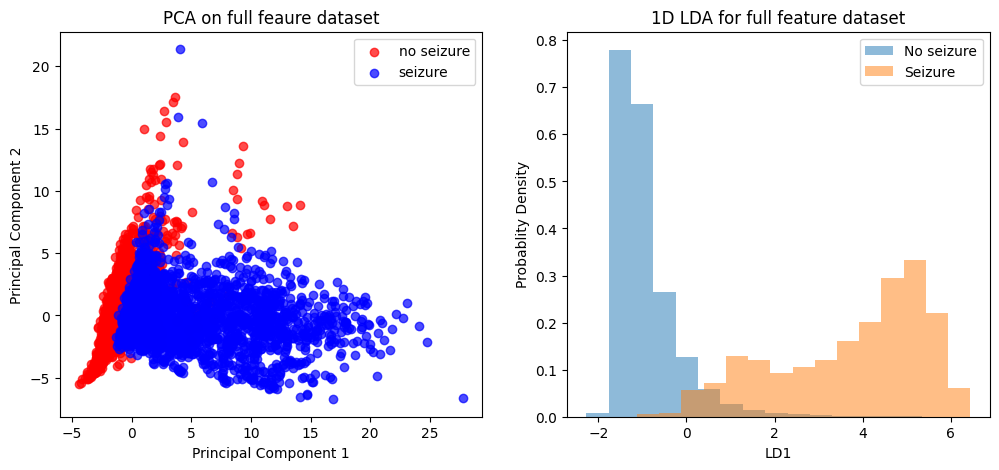

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
colors = ["red", "blue"]
for color, label, name in zip(colors, [0, 1], ["no seizure","seizure"]):
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        alpha=0.7,
        color=color,
        label=name
    )
plt.title("PCA on full feaure dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()



plt.subplot(1, 2, 2)
plt.hist(X_lda[y==0], bins=15, alpha=0.5, label='No seizure', density=True)
plt.hist(X_lda[y==1], bins=15, alpha=0.5, label='Seizure', density=True)
plt.title("1D LDA for full feature dataset")
plt.xlabel("LD1")
plt.ylabel("Probablity Density")
plt.legend()
plt.show()

To achieve linear separability, we must expand our feature space by incorporating more principal components (PCs). With eight PCs, 90% of the feature variance is explained, making it a reasonable upper bound for defining the separation space.

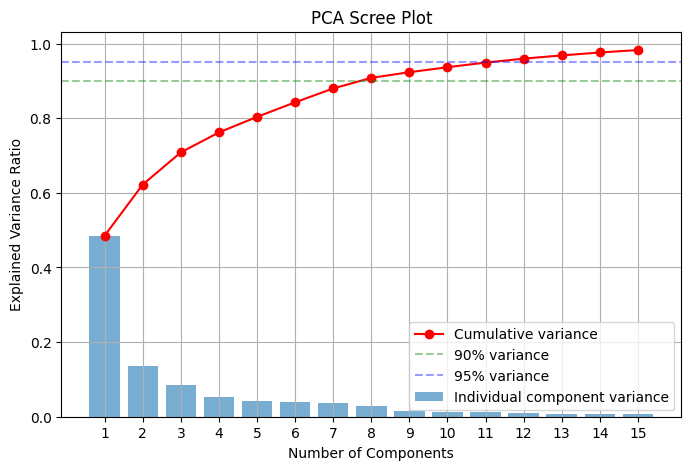

In [22]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot individual explained variance ratios
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_,
        alpha=0.6,
        label='Individual component variance')

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1),
         cumulative_explained_variance,
         marker='o',
         color='red',
         label='Cumulative variance')

plt.axhline(y=0.9, color='green', linestyle='--', label='90% variance', alpha=0.4)
plt.axhline(y=0.95, color='blue', linestyle='--', label='95% variance', alpha=0.4)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Scree Plot')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.legend()
plt.grid(True)
plt.show()

We can make an experiment subsequently adding PC's and try to linearly spearate the dataset with some commo methods

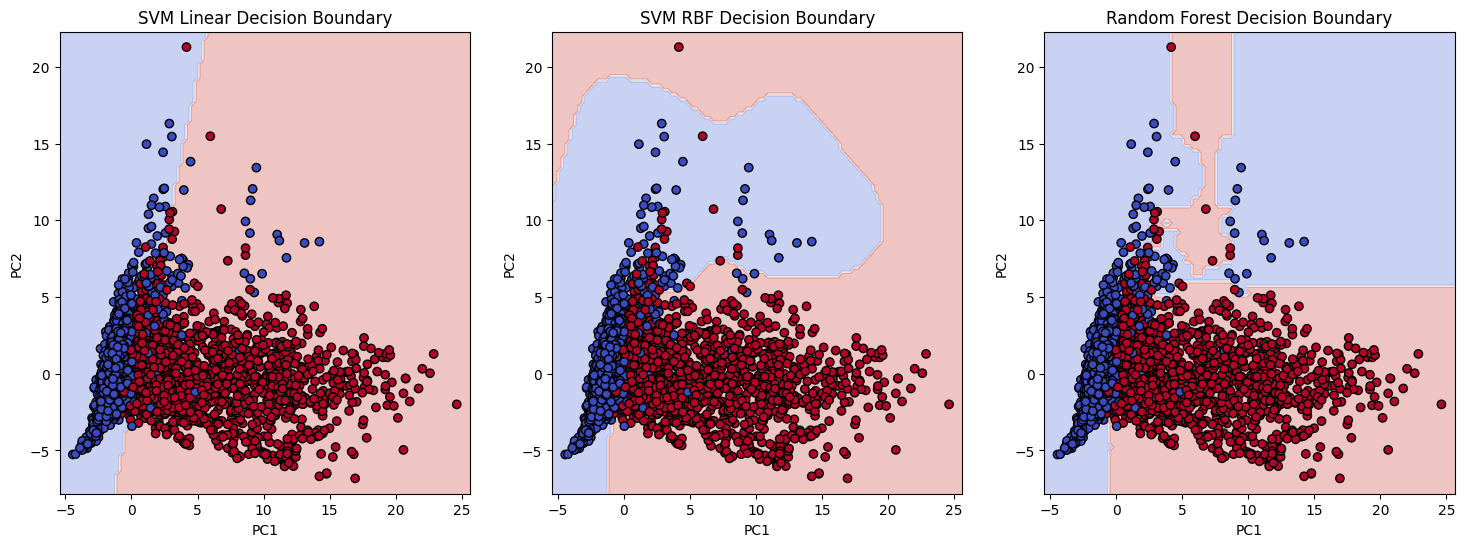

In [33]:
# Required Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize results storage
results = []
misclassified_indices = []

# Train-test split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run experiment for different numbers of principal components
for n_components in range(1, 9):
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_full)
    X_test_pca = pca.transform(X_test_full)
    
    # Train SVM (Linear Kernel)
    svm_linear = SVC(kernel='linear', C=1.0)
    svm_linear.fit(X_train_pca, y_train)
    svm_linear_train_preds = svm_linear.predict(X_train_pca)
    svm_linear_test_preds = svm_linear.predict(X_test_pca)
    
    # Train SVM (RBF Kernel)
    svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_rbf.fit(X_train_pca, y_train)
    svm_rbf_train_preds = svm_rbf.predict(X_train_pca)
    svm_rbf_test_preds = svm_rbf.predict(X_test_pca)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train_pca, y_train)
    rf_train_preds = rf.predict(X_train_pca)
    rf_test_preds = rf.predict(X_test_pca)
    
    # Compute accuracy
    svm_linear_train_acc = accuracy_score(y_train, svm_linear_train_preds)
    svm_linear_test_acc = accuracy_score(y_test, svm_linear_test_preds)
    svm_rbf_train_acc = accuracy_score(y_train, svm_rbf_train_preds)
    svm_rbf_test_acc = accuracy_score(y_test, svm_rbf_test_preds)
    rf_train_acc = accuracy_score(y_train, rf_train_preds)
    rf_test_acc = accuracy_score(y_test, rf_test_preds)

    # Store results
    results.append({
        'n_components': n_components,
        'SVM_Linear_Train_Acc': svm_linear_train_acc, 
        'SVM_Linear_Test_Acc': svm_linear_test_acc,
        'SVM_RBF_Train_Acc': svm_rbf_train_acc, 
        'SVM_RBF_Test_Acc': svm_rbf_test_acc,
        'RF_Train_Acc': rf_train_acc, 
        'RF_Test_Acc': rf_test_acc
    })

    # Compute misclassified indices
    misclassified_indices.append({
        'n_components': n_components,
        'SVM_Linear_Misclassified': np.where(svm_linear_train_preds != y_train)[0].tolist(),
        'SVM_RBF_Misclassified': np.where(svm_rbf_train_preds != y_train)[0].tolist(),
        'RF_Misclassified': np.where(rf_train_preds != y_train)[0].tolist()
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
misclassified_df = pd.DataFrame(misclassified_indices)

# PCA with 2 components for decision boundary plots
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_full)
X_test_pca = pca.transform(X_test_full)

# Train classifiers
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear.fit(X_train_pca, y_train)

svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf.fit(X_train_pca, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)

# Plot decision boundaries for PC2
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# SVM Linear Decision Boundary
Z_svm_linear = svm_linear.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[0].contourf(xx, yy, Z_svm_linear, alpha=0.3, cmap='coolwarm')
axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')
axes[0].set_title("SVM Linear Decision Boundary")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# SVM RBF Decision Boundary
Z_svm_rbf = svm_rbf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[1].contourf(xx, yy, Z_svm_rbf, alpha=0.3, cmap='coolwarm')
axes[1].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')
axes[1].set_title("SVM RBF Decision Boundary")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

# Random Forest Decision Boundary
Z_rf = rf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
axes[2].contourf(xx, yy, Z_rf, alpha=0.3, cmap='coolwarm')
axes[2].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', edgecolor='k')
axes[2].set_title("Random Forest Decision Boundary")
axes[2].set_xlabel("PC1")
axes[2].set_ylabel("PC2")

# Show plots
plt.show()



In [35]:
pd.DataFrame(misclassified_indices)

,n_components,SVM_Linear_Misclassified,SVM_RBF_Misclassified,RF_Misclassified
0,1,"[0, 7, 8, 19, 50, 51, 58, 85, 101, 111, 125, 1...","[8, 19, 44, 51, 58, 85, 88, 101, 125, 126, 143...",[]
1,2,"[0, 3, 7, 8, 19, 50, 58, 72, 85, 101, 125, 126...","[0, 3, 7, 8, 19, 21, 44, 79, 85, 88, 101, 125,...",[]
2,3,"[0, 3, 7, 8, 19, 21, 44, 50, 51, 58, 72, 79, 8...","[3, 19, 21, 44, 79, 85, 88, 101, 125, 126, 151...",[]
3,4,"[0, 3, 7, 8, 19, 21, 44, 50, 51, 58, 72, 79, 8...","[3, 21, 44, 79, 85, 88, 101, 125, 126, 151, 17...",[]
4,5,"[0, 3, 7, 8, 19, 21, 44, 50, 51, 58, 72, 79, 8...","[3, 21, 44, 79, 85, 88, 101, 126, 151, 175, 18...",[]
5,6,"[0, 3, 7, 8, 19, 21, 44, 50, 58, 72, 79, 85, 1...","[44, 79, 85, 101, 151, 175, 188, 207, 213, 244...",[]
6,7,"[0, 3, 7, 8, 19, 21, 44, 50, 58, 79, 85, 101, ...","[79, 85, 101, 126, 151, 175, 188, 207, 244, 30...",[]
7,8,"[0, 7, 8, 19, 44, 79, 85, 101, 125, 126, 175, ...","[44, 79, 85, 101, 126, 151, 175, 188, 207, 244...",[]


In [36]:
results_df

,n_components,SVM_Linear_Train_Acc,SVM_Linear_Test_Acc,SVM_RBF_Train_Acc,SVM_RBF_Test_Acc,RF_Train_Acc,RF_Test_Acc
0,1,0.946304,0.956522,0.958804,0.962174,1.0,0.935652
1,2,0.951630,0.958696,0.965000,0.966522,1.0,0.964348
2,3,0.951304,0.960000,0.968804,0.976522,1.0,0.974348
3,4,0.951630,0.961304,0.970435,0.976522,1.0,0.977391
4,5,0.952717,0.961739,0.973804,0.978261,1.0,0.979130
5,6,0.952717,0.961304,0.977935,0.982174,1.0,0.982174
6,7,0.953587,0.961739,0.978261,0.982609,1.0,0.980870
7,8,0.960652,0.964783,0.978370,0.983043,1.0,0.981304


We need to look for patterns in missclassified rows. Maybe feature selection notebook is useful here. 